In [79]:
import torch
import torch.nn as nn
import torch.fx as fx
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Loading data and Defining transformation needed

In [80]:
DATA_ROOT = "../data"
tx = transforms.ToTensor()

Initializing training dataset. (flag train refers to training set)

In [81]:
train_ds = datasets.MNIST(
    root=DATA_ROOT,
    train=True,
    transform=tx,
    download=True
)
print(len(train_ds))

test_ds = datasets.MNIST(
    root=DATA_ROOT,
    train=False,
    transform=tx,
    download=True
)
print(len(test_ds))

60000
10000


Defining dataloader for training, with batch size being 64 and shuffling

In [82]:
train_loader = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    test_ds,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [83]:
images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


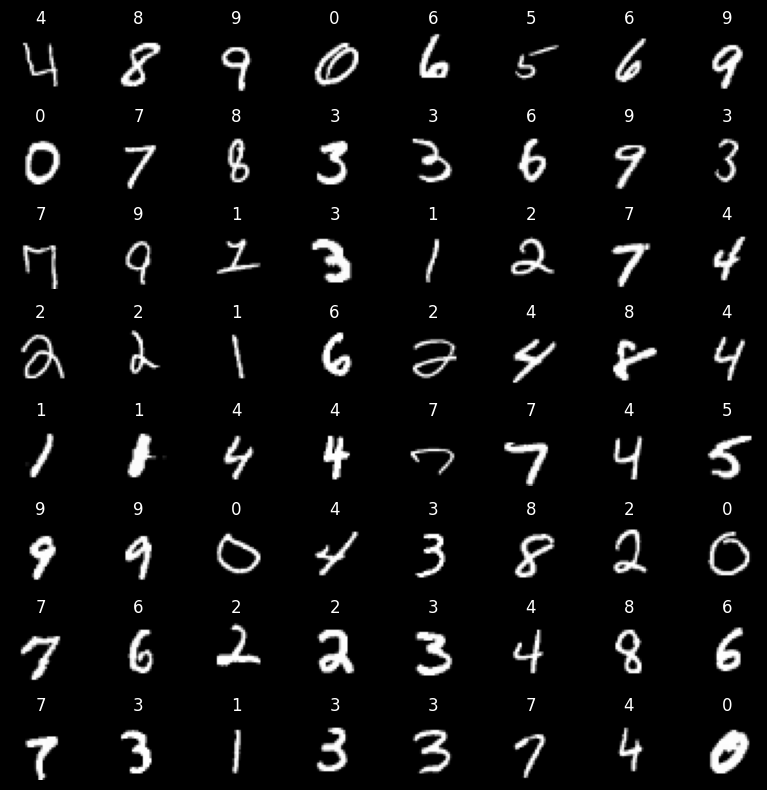

In [84]:
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.axis("off")
    plt.imshow(images[i].squeeze(0), cmap="gray")
    plt.title(int(labels[i]))

plt.tight_layout()
plt.show()

In [85]:
class MINSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128) # (28, 28) -> 128
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10) # 128 -> 10

    def forward(self, x):
        # view changes the dimension while fixing the ordering of the pixels, "-1" is for auto calculation in dimension
        x = x.view(x.size(0), -1) # this requires (batch size, 784) of data, so have to send entire image in all at once
        fc1 = self.fc1(x)
        relu = self.relu(fc1)
        fc2 = self.fc2(relu)
        return fc2

net = MINSTClassifier()
print(net)
test_result = net.forward(images.squeeze(0))
print(test_result.shape)

MINSTClassifier(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
torch.Size([64, 10])


In [86]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc1(x)

In [87]:
model_ML = LogisticRegression()
criterion_ML = nn.CrossEntropyLoss()
optimizer_ML = torch.optim.SGD(model_ML.parameters(), lr=0.01)

model_NN = MINSTClassifier()
criterion_NN = nn.CrossEntropyLoss()
optimizer_NN = torch.optim.Adam(model_NN.parameters(), lr=0.001)

In [88]:
def eval_model(model, criterion, loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    running_eval_loss = 0
    with torch.no_grad():
        for x, y in loader:
            total_samples += y.size(0)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            running_eval_loss += loss.item()
            pred = y_pred.argmax(dim=1)
            total_correct += (pred == y).sum().item()
    avg_loss = running_eval_loss / len(loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

ML_loss = []
ML_acc = []
NN_loss = []
NN_acc = []

num_epochs = 10
for epoch in range(num_epochs):
    # --- Train ML baseline ---
    model_ML.train()
    running_loss_ML = 0
    for x, y in train_loader:
        y_pred = model_ML(x)
        loss = criterion_ML(y_pred, y)
        optimizer_ML.zero_grad()
        loss.backward()
        optimizer_ML.step()
        running_loss_ML += loss.item()
    train_loss_ML = running_loss_ML / len(train_loader)
    val_loss_ML, accuracy_ML = eval_model(model_ML, criterion_ML, test_loader)
    print(
        f"Epoch {epoch+1:02d}/{num_epochs} | "
        f"ML  train={train_loss_ML:.4f}  val={val_loss_ML:.4f}  acc={accuracy_ML*100:5.2f}%"
    )
    ML_loss.append(val_loss_ML)
    ML_acc.append(accuracy_ML)

for epoch in range(num_epochs):
    # --- Train MLP ---
    model_NN.train()
    running_loss_NN = 0
    for x, y in train_loader:
        y_pred = model_NN(x)
        loss = criterion_NN(y_pred, y)
        optimizer_NN.zero_grad()
        loss.backward()
        optimizer_NN.step()
        running_loss_NN += loss.item()
    train_loss_NN = running_loss_NN / len(train_loader)
    val_loss_NN, accuracy_NN = eval_model(model_NN, criterion_NN, test_loader)

    print(
        f"Epoch {epoch+1:02d}/{num_epochs} | "
        f"NN  train loss={train_loss_NN:.4f}  test loss={val_loss_NN:.4f}  acc={accuracy_NN*100:5.2f}%"
    )
    NN_loss.append(val_loss_NN)
    NN_acc.append(accuracy_NN)

Epoch 01/10 | ML  train=0.9775  val=0.5998  acc=86.93%
Epoch 02/10 | ML  train=0.5513  val=0.4754  acc=88.41%
Epoch 03/10 | ML  train=0.4717  val=0.4252  acc=89.12%
Epoch 04/10 | ML  train=0.4330  val=0.3967  acc=89.60%
Epoch 05/10 | ML  train=0.4090  val=0.3786  acc=89.85%
Epoch 06/10 | ML  train=0.3922  val=0.3649  acc=90.05%
Epoch 07/10 | ML  train=0.3794  val=0.3540  acc=90.42%
Epoch 08/10 | ML  train=0.3696  val=0.3464  acc=90.55%
Epoch 09/10 | ML  train=0.3614  val=0.3394  acc=90.71%
Epoch 10/10 | ML  train=0.3546  val=0.3339  acc=90.91%
Epoch 01/10 | NN  train loss=0.3483  test loss=0.1952  acc=94.22%
Epoch 02/10 | NN  train loss=0.1634  test loss=0.1321  acc=96.08%
Epoch 03/10 | NN  train loss=0.1141  test loss=0.1091  acc=96.64%
Epoch 04/10 | NN  train loss=0.0865  test loss=0.0986  acc=97.08%
Epoch 05/10 | NN  train loss=0.0680  test loss=0.0825  acc=97.53%
Epoch 06/10 | NN  train loss=0.0544  test loss=0.0798  acc=97.66%
Epoch 07/10 | NN  train loss=0.0443  test loss=0.0778 

In [89]:
import numpy as np

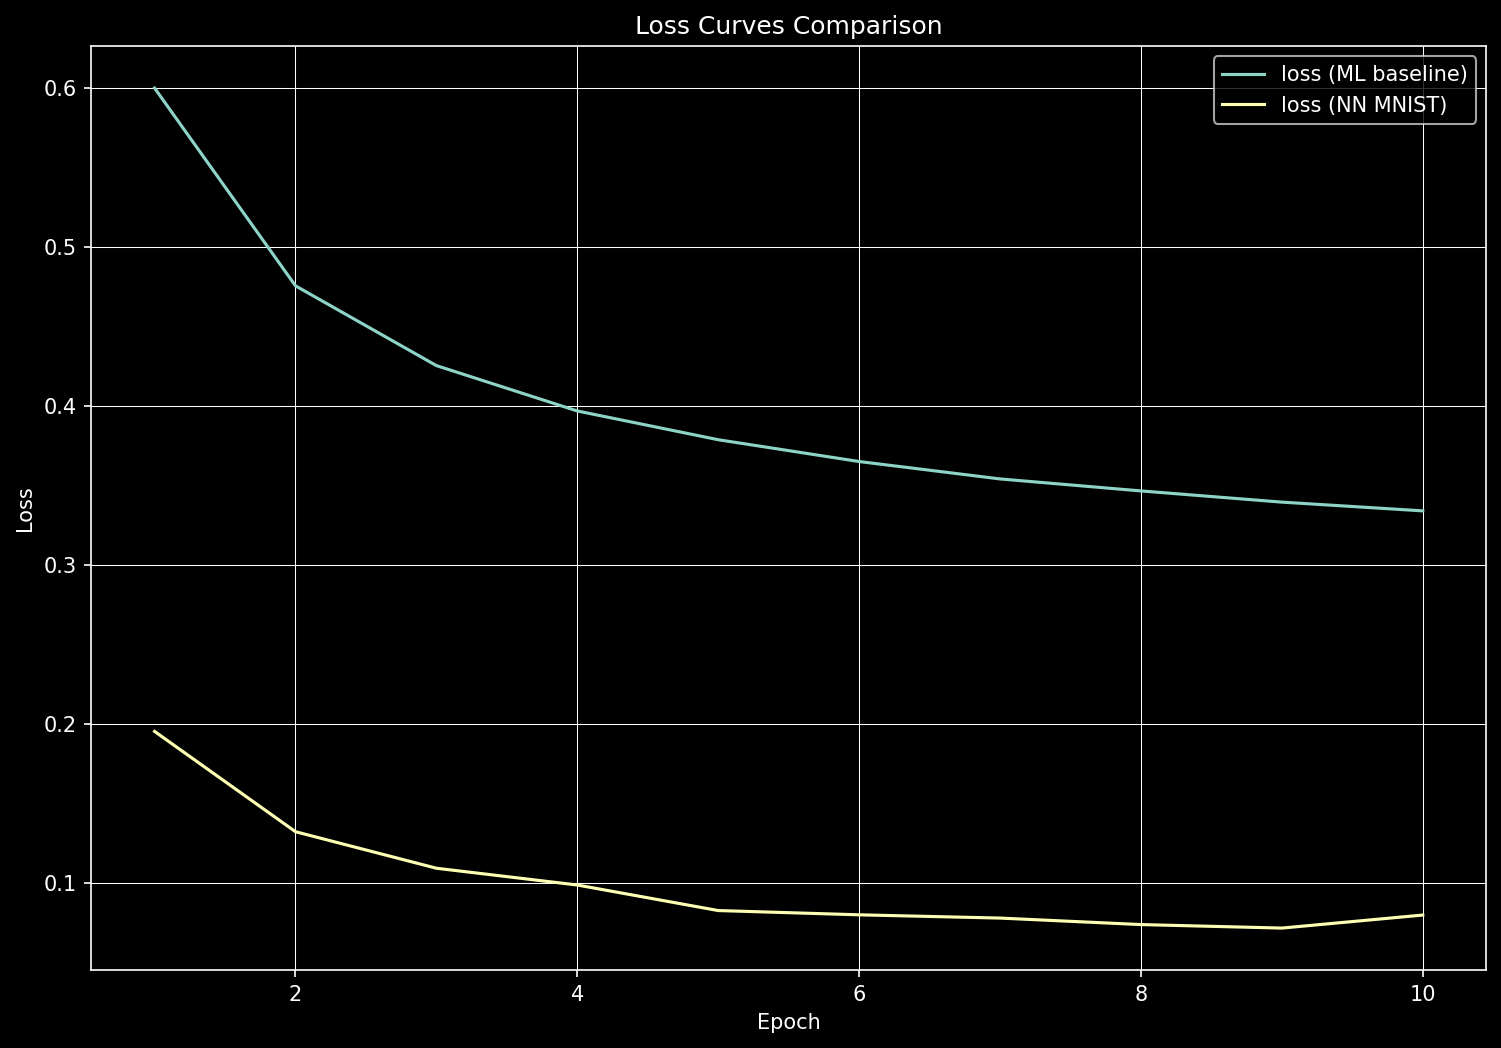

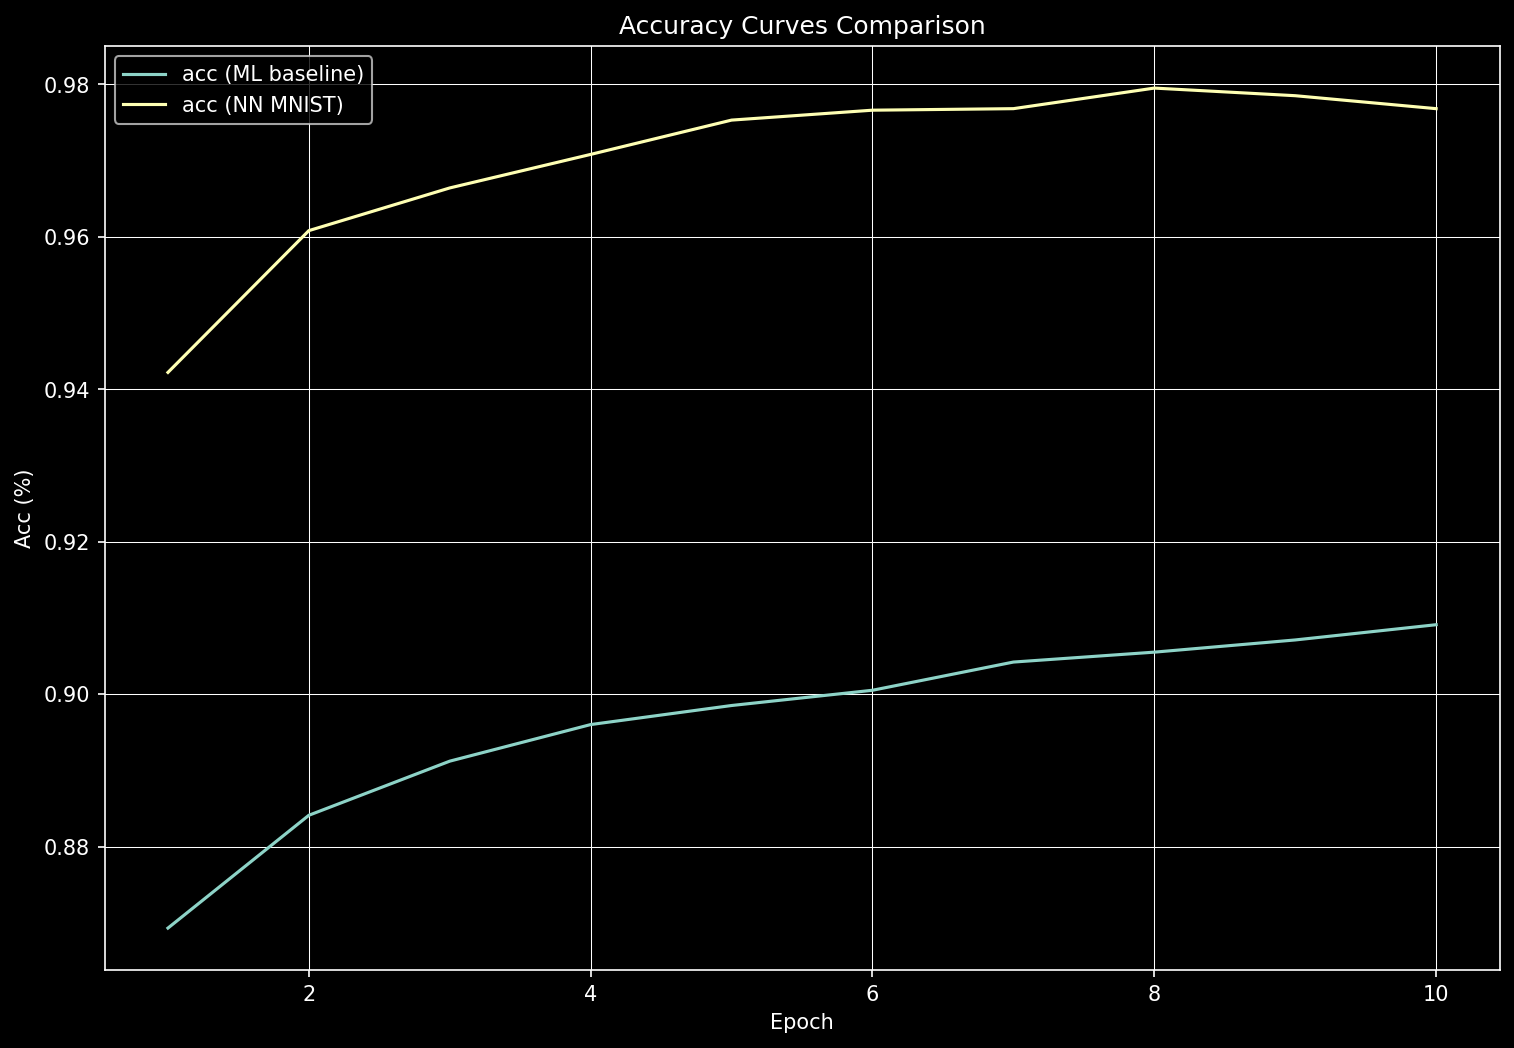

In [124]:
plt.style.use("dark_background")

epoch_x = np.arange(1, 11)
plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, ML_loss, label='loss (ML baseline)')
plt.plot(epoch_x, NN_loss, label='loss (NN MNIST)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves Comparison")
plt.savefig("../results/loss_curve.png")
plt.show()

plt.figure(figsize=(12, 8), dpi=150)
plt.plot(epoch_x, ML_acc, label='acc (ML baseline)')
plt.plot(epoch_x, NN_acc, label='acc (NN MNIST)')
plt.grid(True, linewidth=0.5)
plt.xlabel("Epoch")
plt.ylabel("Acc (%)")
plt.legend()
plt.title("Accuracy Curves Comparison")
plt.savefig("../results/acc_curve.png")
plt.show()

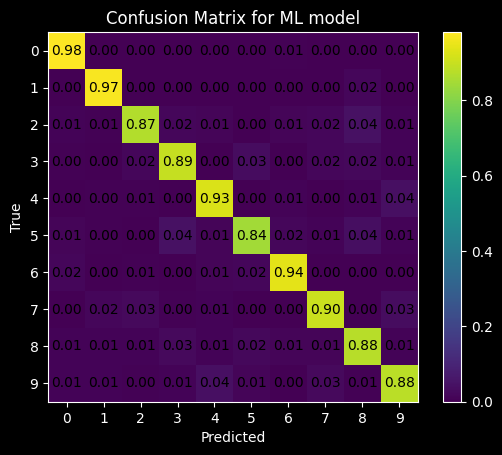

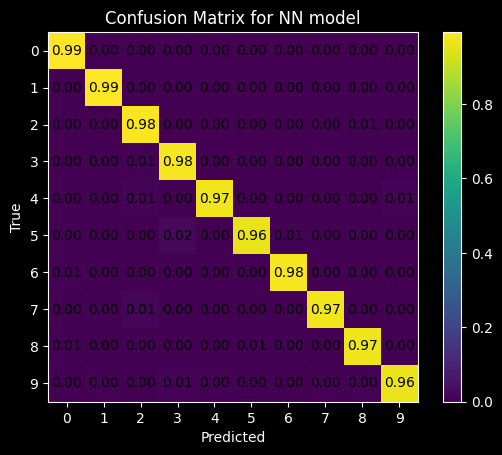

In [125]:
def plot_conf_matrix(model, loader, filename):
    num_classes = 10
    conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            y_true = y
            y_pred = model(x).argmax(dim=1)
            for t, p in zip(y_true, y_pred):
                conf_matrix[t, p] += 1
                
    conf_matrix = conf_matrix.float()
    conf_matrix = conf_matrix / conf_matrix.sum(dim=1, keepdim=True)
    conf_matrix = torch.nan_to_num(conf_matrix)
    plt.imshow(conf_matrix, cmap="viridis")
    plt.colorbar()
    class_labels = np.arange(0, 10)
    plt.xticks(range(num_classes), class_labels)
    plt.yticks(range(num_classes), class_labels)
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, f"{conf_matrix[i,j]:.2f}", 
                    ha="center", va="center", color="black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix for {filename[-6:-4]} model")
    plt.savefig(f"../results/{filename}")
    plt.show()
    return

plot_conf_matrix(model_ML, test_loader, "confusion_matrix_ML.png")
plot_conf_matrix(model_NN, test_loader, "confusion_matrix_NN.png")